# Introduction

In this notebook, we will be learning the assocation between the traits and attributes of different borrowers in history and their repayment status (i.e. whether they are Good Risk or Bad Risk). <br />
Definition of credit risk: The risk of witnessing defaults on a debt that may arise from a borrower failing to make required payments

Credits: https://towardsdatascience.com/how-do-you-present-your-data-science-solution-961c1d1d8dec

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# split dataset into training and test set
from sklearn.model_selection import train_test_split

df_credit= pd.read_csv('german_credit.csv')
df_train, df_test = train_test_split(df_credit, test_size=0.1, random_state=42)

df_train.shape, df_test.shape

((900, 10), (100, 10))

In [3]:
df_train.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
716,4,40,male,2,own,NaN,3077,30,radio/TV,good
351,2,29,female,2,own,little,959,9,furniture/equipment,bad
936,2,28,female,1,own,little,745,9,radio/TV,bad
256,4,35,male,1,own,little,2684,24,radio/TV,good
635,2,47,male,2,own,little,1393,12,education,good


# Exploratory Data Analysis (EDA)

We will be checking the training and test dataset whether they belong to similar distributions:

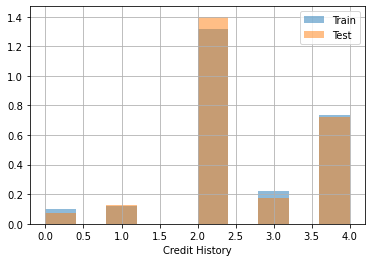

In [4]:
df_train.loc[:, 'Credit History'].hist(alpha=0.5, label='Train', density=True)
df_test.loc[:, 'Credit History'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Credit History')
plt.legend()
plt.show()

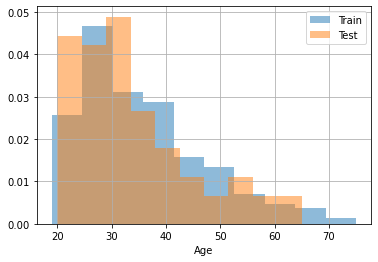

In [5]:
df_train.loc[:, 'Age'].hist(alpha=0.5, label='Train', density=True)
df_test.loc[:, 'Age'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Age')
plt.legend()
plt.show()

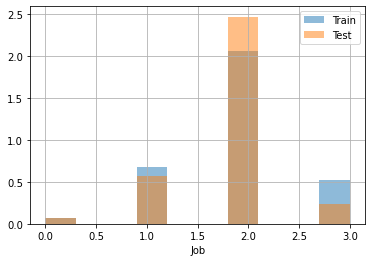

In [6]:
df_train.loc[:, 'Job'].hist(alpha=0.5, label='Train', density=True)
df_test.loc[:, 'Job'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Job')
plt.legend()
plt.show()

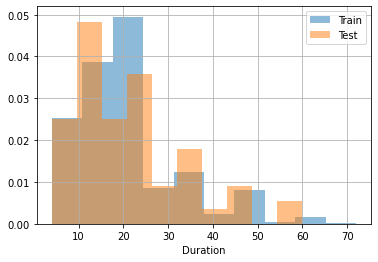

In [7]:
df_train.loc[:, 'Duration'].hist(alpha=0.5, label='Train', density=True)
df_test.loc[:, 'Duration'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Duration')
plt.legend()
plt.show()

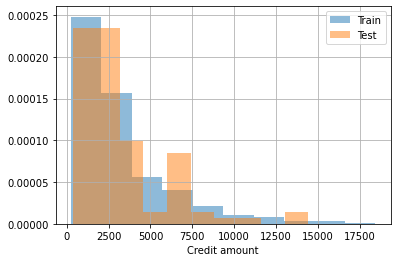

In [8]:
df_train.loc[:, 'Credit amount'].hist(alpha=0.5, label='Train', density=True)
df_test.loc[:, 'Credit amount'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Credit amount')
plt.legend()
plt.show()

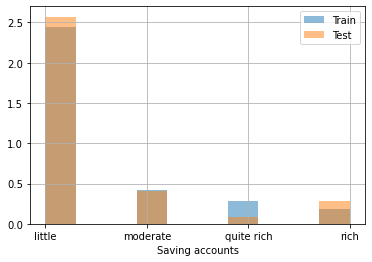

In [9]:
df_train.loc[:, 'Saving accounts'].hist(alpha=0.5, label='Train', density=True)
df_test.loc[:, 'Saving accounts'].hist(alpha=0.5, label='Test', density=True)
plt.xlabel('Saving accounts')
plt.legend()
plt.show()

K-S Statistic is a numeric measure to check the null hypothesis of whether the 2 distributions are identical. <br />
A K-S value smaller than the p-value suggests that we cannot reject the null hypothesis that the two distributions are the same:

In [10]:
from scipy.stats import ks_2samp

print('K-S Statistic')
for i in ('Credit History', 'Age', 'Job', 'Duration', 'Credit amount'):
    print(i, ':', ks_2samp(df_train[i], df_test[i]))

K-S Statistic
Credit History : KstestResult(statistic=0.023333333333333334, pvalue=0.9999999986540478)
Age : KstestResult(statistic=0.10444444444444445, pvalue=0.26508851077956963)
Job : KstestResult(statistic=0.08666666666666667, pvalue=0.4874563836201551)
Duration : KstestResult(statistic=0.03, pvalue=0.9999932472855252)
Credit amount : KstestResult(statistic=0.07222222222222222, pvalue=0.7140534776836482)


From the histograms and K-S values, we can say that the training and test dataset are drawn from a similar distribution.

In [11]:
df_train.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
716,4,40,male,2,own,NaN,3077,30,radio/TV,good
351,2,29,female,2,own,little,959,9,furniture/equipment,bad
936,2,28,female,1,own,little,745,9,radio/TV,bad
256,4,35,male,1,own,little,2684,24,radio/TV,good
635,2,47,male,2,own,little,1393,12,education,good


In [12]:
df_train.nunique()

Credit History       5
Age                 53
Gender               2
Job                  4
Housing              3
Saving accounts      4
Credit amount      833
Duration            33
Purpose              8
Risk                 2
dtype: int64

In [13]:
df_train.Risk.value_counts()

good    629
bad     271
Name: Risk, dtype: int64

In [14]:
df_train_summ = df_train.describe()
df_train_summ

,Credit History,Age,Job,Credit amount,Duration
count,900.000000,900.000000,900.000000,900.000000,900.000000
mean,2.545556,35.716667,1.908889,3279.596667,20.836667
std,1.086438,11.421870,0.664137,2836.781180,11.955283
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,2.000000,27.000000,2.000000,1369.750000,12.000000
50%,2.000000,33.000000,2.000000,2308.500000,18.000000
75%,4.000000,42.000000,2.000000,3976.750000,24.000000
max,4.000000,75.000000,3.000000,18424.000000,72.000000


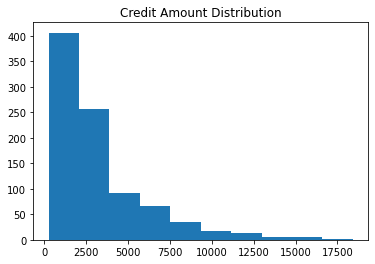

In [15]:
plt.hist(df_train['Credit amount'])
plt.title('Credit Amount Distribution')
plt.show()

The distribution of the credit amount is highly skewed, let's analyse the extreme values beyond 3 sigmas from the mean:

In [16]:
def extreme_count(sig_factor, feat):
    sig_cutoff = df_train_summ[feat]['mean'] + sig_factor * df_train_summ[feat]['std']
    sig_count = len(df_train[df_train[feat] > sig_cutoff])
    print('There are {} instances of {} feature greater than {} sigma. (Cutoff: {})'.format(sig_count, feat, sig_factor, sig_cutoff))
    return

In [17]:
extreme_count(3, 'Credit amount')

There are 22 instances of Credit amount feature greater than 3 sigma. (Cutoff: 11789.940206179203)


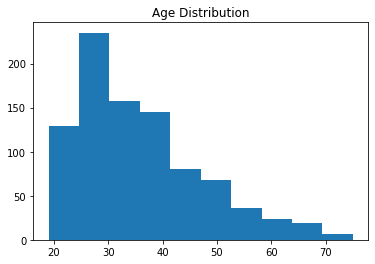

In [18]:
plt.hist(df_train['Age'])
plt.title('Age Distribution')
plt.show()

In [19]:
extreme_count(3, 'Age')

There are 7 instances of Age feature greater than 3 sigma. (Cutoff: 69.98227757924869)


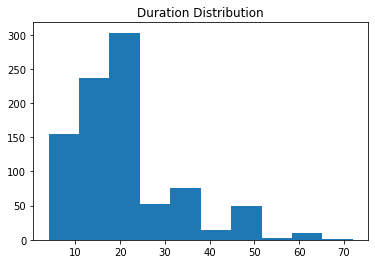

In [20]:
plt.hist(df_train['Duration'])
plt.title('Duration Distribution')
plt.show()

In [21]:
extreme_count(3, 'Duration')

There are 11 instances of Duration feature greater than 3 sigma. (Cutoff: 56.702516551852156)


Although these instances have features which are beyond 3 sigma of their mean values, we are not treating them as outliers as some loans will have high credit value or longer loan durations etc.

In [22]:
df_train.isnull().sum()

Credit History       0
Age                  0
Gender               0
Job                  0
Housing              0
Saving accounts    166
Credit amount        0
Duration             0
Purpose              0
Risk                 0
dtype: int64

Only the 'Saving accounts' feature has null values. After checking it, the null values imply that there is no saving account for that particular instance, hence we will be imputing the null values:

In [23]:
print(df_train['Saving accounts'].value_counts())
print(df_train['Saving accounts'].unique())

little        539
moderate       93
quite rich     61
rich           41
Name: Saving accounts, dtype: int64
[nan 'little' 'moderate' 'quite rich' 'rich']


In [24]:
# replace null values with 'no account'
df_train.loc[df_train['Saving accounts'].isnull(), 'Saving accounts'] = 'no account'

In [25]:
df_train.isnull().sum()

Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64

In [26]:
df_train.dtypes

Credit History      int64
Age                 int64
Gender             object
Job                 int64
Housing            object
Saving accounts    object
Credit amount       int64
Duration            int64
Purpose            object
Risk               object
dtype: object

Next, we will be label encoding the categorical features:

In [27]:
cat_attribs = df_credit.select_dtypes(include='object').columns
cat_attribs

Index(['Gender', 'Housing', 'Saving accounts', 'Purpose', 'Risk'], dtype='object')

In [28]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for feat in cat_attribs:
    df_train[feat] = encoder.fit_transform(df_train[feat])

In [29]:
df_train.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
716,4,40,1,2,1,2,3077,30,5,1
351,2,29,0,2,1,0,959,9,4,0
936,2,28,0,1,1,0,745,9,5,0
256,4,35,1,1,1,0,2684,24,5,1
635,2,47,1,2,1,0,1393,12,3,1


In [30]:
df_train.Risk.value_counts()

1    629
0    271
Name: Risk, dtype: int64

In [31]:
df_train.corr()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
Credit History,1.000000,0.148363,0.078987,0.004217,-0.068106,0.035619,-0.063109,-0.076802,0.015034,0.236102
Age,0.148363,1.000000,0.168368,0.019909,-0.298159,0.079027,0.036005,-0.045435,-0.079569,0.102314
Gender,0.078987,0.168368,1.000000,0.060399,-0.223024,0.002926,0.084763,0.067744,-0.052779,0.085402
Job,0.004217,0.019909,0.060399,1.000000,-0.092980,-0.028781,0.284859,0.208546,-0.000328,-0.039012
Housing,-0.068106,-0.298159,-0.223024,-0.092980,1.000000,0.025598,-0.129149,-0.139828,0.009992,-0.025736
Saving accounts,0.035619,0.079027,0.002926,-0.028781,0.025598,1.000000,-0.004276,0.010221,-0.011529,0.162159
Credit amount,-0.063109,0.036005,0.084763,0.284859,-0.129149,-0.004276,1.000000,0.620168,-0.132603,-0.151349
Duration,-0.076802,-0.045435,0.067744,0.208546,-0.139828,0.010221,0.620168,1.000000,-0.065349,-0.201140
Purpose,0.015034,-0.079569,-0.052779,-0.000328,0.009992,-0.011529,-0.132603,-0.065349,1.000000,0.067481
Risk,0.236102,0.102314,0.085402,-0.039012,-0.025736,0.162159,-0.151349,-0.201140,0.067481,1.000000


Note that 'Credit amount' has high correlation with 'Duration'. Hence we can consider on dropping one of the features.

### Subquestion 1: Credit History vs Risk

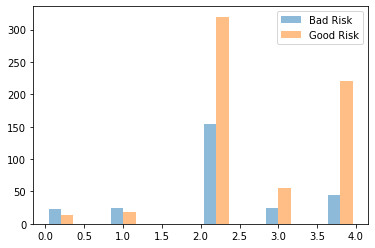

In [32]:
plt.hist([df_train.loc[df_train['Risk'] == 0, 'Credit History'].values, 
          df_train.loc[df_train['Risk'] == 1, 'Credit History'].values], alpha=0.5, label=['Bad Risk', 'Good Risk'])
plt.legend(loc='upper right')
plt.show()

In general, as credit history increases, it will increase the likelyhood of good risk.

### Subquestion 2: Age vs Risk

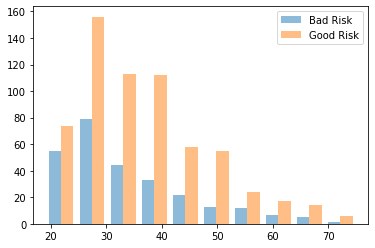

In [33]:
plt.hist([df_train.loc[df_train['Risk'] == 0, 'Age'].values, 
          df_train.loc[df_train['Risk'] == 1, 'Age'].values], alpha=0.5, label=['Bad Risk', 'Good Risk'])
plt.legend(loc='upper right')
plt.show()

We will divide the age into 3 bins:

In [34]:
df_train.Age[df_train.Age <= 30] = 0
df_train.Age[(df_train.Age > 30) & (df_train.Age < 45)] = 1
df_train.Age[df_train.Age >= 45] = 2

In [35]:
df_train[df_train['Risk'] == 1]['Age'].value_counts() / df_train['Age'].value_counts()

0    0.631868
1    0.734286
2    0.763441
Name: Age, dtype: float64

The figures above indicate that young people have a smaller proportion of having good credit.

### Subquestion 3: Saving Accounts vs Risk

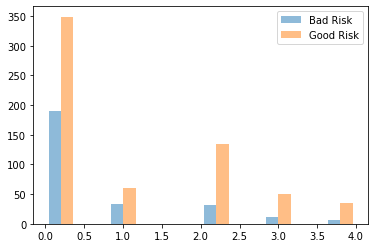

In [36]:
plt.hist([df_train.loc[df_train['Risk'] == 0, 'Saving accounts'].values, 
          df_train.loc[df_train['Risk'] == 1, 'Saving accounts'].values], alpha=0.5, label=['Bad Risk', 'Good Risk'])
plt.legend(loc='upper right')
plt.show()

It is unclear that having more saving accounts leads to good or bad risk in general.

# Data Preparation and Modeling

In [37]:
y_train = df_train['Risk']
X_train = df_train.drop(columns=['Risk'])

In [38]:
df_test.isnull().sum()

Credit History      0
Age                 0
Gender              0
Job                 0
Housing             0
Saving accounts    17
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [39]:
df_test.loc[df_test['Saving accounts'].isnull(), 'Saving accounts'] = 'no account'

In [40]:
df_test.isnull().sum()

Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64

In [41]:
for feat in cat_attribs:
    df_test[feat] = encoder.fit_transform(df_test[feat])

In [42]:
df_test.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
521,2,24,0,2,1,0,3190,18,4,0
737,2,35,1,1,1,1,4380,18,1,1
740,1,32,1,2,1,1,2325,24,1,1
660,2,23,1,2,2,0,1297,12,4,1
411,4,35,1,3,1,0,7253,33,1,1


In [43]:
y_test = df_test['Risk']
X_test = df_test.drop(columns=['Risk'])

In [44]:
y_train.shape, y_test.shape, X_train.shape, X_test.shape

((900,), (100,), (900, 9), (100, 9))

We will be using cross validation and the F-beta score for the evaluation metrics. In this project, we are more inclined towards putting more weight on precision (reducing false positive instances). Hence we set beta < 1:

In [45]:
from sklearn.metrics import fbeta_score, make_scorer

ftwo_scorer = make_scorer(fbeta_score, beta=1/5)

In [46]:
fbeta_mu_score, fbeta_sigma_score = [], []

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model_list = [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()]
for model in model_list:
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=ftwo_scorer)
    fbeta_mu_score.append(np.mean(score))
    fbeta_sigma_score.append(np.std(score))

In [48]:
fbeta_mu_score, fbeta_sigma_score

([0.75703855582724, 0.7722871005713541, 0.75322966265873],
 [0.02213894473353152, 0.012044502635506474, 0.013119472634670858])

The best model among the three is the RandomForestClassifier() model.

In [49]:
model_index = fbeta_mu_score.index(max(fbeta_mu_score))
selected_model = model_list[model_index]
selected_model

RandomForestClassifier()

In [50]:
selected_model = RandomForestClassifier()
selected_model.fit(X_train, y_train)
y_pred = selected_model.predict(X_test)
fbeta_score(y_test, y_pred, beta=1/5)

0.7609185051778479

Finally, we can find out which features contribute the most on determining the credit risk:

In [51]:
df_feat = pd.DataFrame()
df_feat['cols'] = X_train.columns
df_feat['importance'] = selected_model.feature_importances_
df_feat

,cols,importance
0,Credit History,0.110526
1,Age,0.064704
2,Gender,0.035489
3,Job,0.064644
4,Housing,0.052101
5,Saving accounts,0.078604
6,Credit amount,0.314790
7,Duration,0.174862
8,Purpose,0.104279


In [52]:
top_3 = list(df_feat.sort_values(by='importance', ascending=False).head(3)['cols'].values)
print('Top 3 features:', top_3)
print('Cumulative importance:', np.round(100 * df_feat.sort_values(by='importance', ascending=False).head(3)['importance'].sum()))

Top 3 features: ['Credit amount', 'Duration', 'Credit History']
Cumulative importance: 60.0
